In [1]:
# import the file and load it in the hypernetwork, load the model, create a batch and test the performance of the mlp
# then the interesting part is the riconstruction of the parameters.

In [1]:
from pathlib import Path

import torch

import control

import numpy as np

import pandas as pdPath
from dataset import WHDataset_Model
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
# from transformer_sim import Config, TSTransformer, DecoderOnlyInteractionModel
from model import TransformerEncoder, WHModel, Config
import metrics
import matplotlib.colors as colors
import copy
import torch.nn as nn
from torch.func import vmap, grad, functional_call
import time
import nonlinear_benchmarks
from nonlinear_benchmarks.error_metrics import RMSE
import math
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [2]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(452)
np.random.seed(55)
system_seed = 66 # Controls the system generation
data_seed = 0 # Controls the input generation

In [3]:
# Overall settings
out_dir_name = "check_WH_over_WH"

# System settings
nu = 1
ny = 1
batch_size = 128
fixed_system = False # Are we testing on a fixed system?

# Compute settings
no_cuda = False
threads = 5
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  =  "cpu"
device = torch.device(device_name)
device_type = 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")

In [4]:
# Create out dir
out_dir = Path(out_dir_name)
#SEED1

exp_data = torch.load(out_dir / "test_WH_lr1e3_nonorm_3mil.pt", map_location=device)
exp_data2 = torch.load(out_dir / "400_classic/ckpt_430_fine-tuned_2000000_lower_noise.pt", map_location=device)


cfg = exp_data["cfg"]
cfg2 = exp_data2["cfg"]
# For compatibility with initial experiment without seed
try:
    cfg.seed
except AttributeError:
    cfg.seed = None


In [5]:
exp_data["iter_num"]

1382000

In [6]:
exp_data["model_args"]

{'n_layers': 12,
 'n_head': 4,
 'n_y': 1,
 'n_u': 1,
 'n_x': 5,
 'seq_len_ctx': 400,
 'seq_len_new': 100,
 'bias': False,
 'dropout': 0.0,
 'device_name': 'cuda:0',
 'd_model': 64,
 'n_hidden': 32}

In [7]:
model_args = exp_data2["model_args"]
conf = Config(**model_args)
# model = DecoderOnlyInteractionModel(conf).to(device)
model = TSTransformer(conf).to(device)
model.load_state_dict(exp_data2["model"]);
noise_std = 0.0
# Create data loader
lin_opts = dict(mag_range=cfg.mag_range, phase_range=cfg.phase_range, strictly_proper=True)
test_ds = WHDataset(nx=cfg.nx, nu=cfg.nu, ny=cfg.ny, 
                                        seq_len=cfg.seq_len_ctx+cfg.seq_len_skip+30+cfg.seq_len_new,
                        system_seed=cfg2.seed, input_seed=cfg2.seed+1, noise_seed=cfg2.seed+2,
                        **lin_opts)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=1)
batch_y, batch_u= next(iter(test_dl))

with torch.no_grad():
    batch_y_ctx = batch_y[:, :cfg.seq_len_ctx, :]
    batch_u_ctx = batch_u[:, :cfg.seq_len_ctx, :]
    batch_y_new = batch_y[:, cfg.seq_len_ctx+cfg.seq_len_skip:, :]
    batch_u_new = batch_u[:, cfg.seq_len_ctx+cfg.seq_len_skip:, :]
    # print(torch.cat([batch_u_ctx,batch_u_new], dim = 1).shape)
    batch_y_mean = torch.zeros([batch_size,cfg.seq_len_new,len(batch_y_ctx)])
    batch_y_std = torch.zeros([batch_size,cfg.seq_len_new,len(batch_y_ctx)])

    batch_y_mean,_,_,_,_ = model(batch_y_ctx.float(),batch_u_ctx.float(),batch_u_new,batch_y_new,30)
    # batched_wh_simulation = torch.vmap(wh_simulation)
    # batch_y_mean = batched_wh_simulation(wh_parameters_batch, batch_u)
    # batch_y_mean = batched_wh_simulation(wh_parameters_batch, )
    # print(batch_y_mean.shape)
    # param_list = []
    # for name, param in wh.named_parameters():
        # param_from_hyper = wh_parameters_batch[name]
    #     param_list.append(param_from_hyper.reshape(-1))
    # params_hypernet_vector = torch.cat(param_list)  # shape: (total_num_params,)


TypeError: Config.__init__() got an unexpected keyword argument 'n_layer'

In [6]:
n_hidden = 32
wh = WHModel(cfg.nx,hidden_dim=n_hidden).to(device)
params_WH = dict(wh.named_parameters())
flat_params_WH = nn.utils.parameters_to_vector(wh.parameters())
n_params_WH = flat_params_WH.shape[0]

In [7]:
model_args = exp_data["model_args"]
conf = Config(**model_args)
hypernet = TransformerEncoder(conf).to(device)
# model = TSTransformer_paper(conf).to(device)/
hypernet.load_state_dict(exp_data["model"]);
# cfg.seed +=1

In [8]:
# Create data loader
lin_opts = dict(mag_range=cfg.mag_range, phase_range=cfg.phase_range, strictly_proper=True)
test_ds = WHDataset_Model(nx=cfg.nx, nu=cfg.nu, ny=cfg.ny, 
                                        seq_len=cfg.seq_len_ctx+cfg.seq_len_skip+cfg.seq_len_n_in+cfg.seq_len_new,
                        system_seed=cfg.seed, input_seed=cfg.seed+1, noise_seed=cfg.seed+2,
                        **lin_opts)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=1)

In [9]:
def wh_simulation(params, x):
    y_hat = functional_call(wh, params, x)
    # y_hat = (y_hat-y_hat.mean(axis = 0))/(y_hat.std(axis = 0)+1e-8)

    # params: parameters for a single WH model (dict or OrderedDict)
    # x: input for a single system
    return y_hat

In [10]:
batch_y, batch_u,params= next(iter(test_dl))
batch_y = batch_y.to(device)
batch_u = batch_u.to(device)
noise_std = 0.0
with torch.no_grad():
    batch_y_ctx = batch_y[:, :cfg.seq_len_ctx, :]
    batch_u_ctx = batch_u[:, :cfg.seq_len_ctx, :]
    batch_y_new = batch_y[:, cfg.seq_len_ctx+cfg.seq_len_skip:, :]
    batch_u_new = batch_u[:, cfg.seq_len_ctx+cfg.seq_len_skip:, :]
    batch_y_mean = torch.zeros([batch_size,cfg.seq_len_new,len(batch_y_ctx[0,0,:])])
    batch_y_std = torch.zeros([batch_size,cfg.seq_len_new,len(batch_y_ctx[0,0,:])])

    wh_parameters_batch,_,_ = hypernet(batch_u_ctx,batch_y_ctx,wh,params)
    batched_wh_simulation = torch.vmap(wh_simulation)
    batch_y_mean = batched_wh_simulation(wh_parameters_batch, batch_u)
    print(batch_y_mean.shape)
    # param_list = []
    # for name, param in wh.named_parameters():
    #     param_from_hyper = wh_parameters_batch[name]
    #     param_list.append(param_from_hyper.reshape(-1))
    # params_hypernet_vector = torch.cat(param_list)  # shape: (total_num_params,)

/home/mrufolo/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


torch.Size([128, 950, 1])


tensor([0.5167, 0.5167, 0.5965, 0.5372, 0.5274], dtype=torch.float64)


/home/mrufolo/.local/lib/python3.10/site-packages/control/freqplot.py:454: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


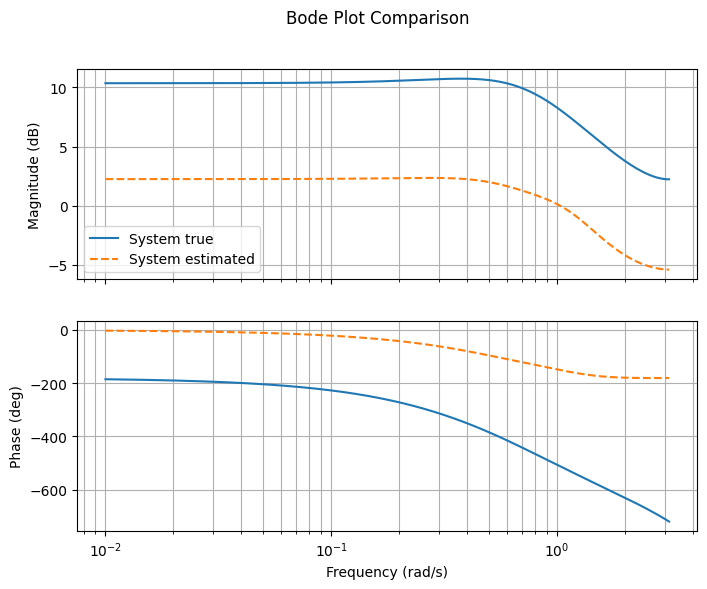

norm (True system): 2.2910579393940713
norm (Estimated system): 0.8900004175522908
Suggested scale correction factor for true system: 0.4365
Suggested scale correction factor for estimated system: 1.1236
H2 norm of difference: 2.3352
Hinf norm of difference: 4.4815
H2 norm of difference: 1.3083
[[-1.437509]] [[1.45718224]]
[[1.437509]] [[1.45718224]]
H2 norm of the real: 1.0 H2 norm of estimated: 1.0
H2 norm of difference: 1.5127
Hinf norm of difference: 2.5195


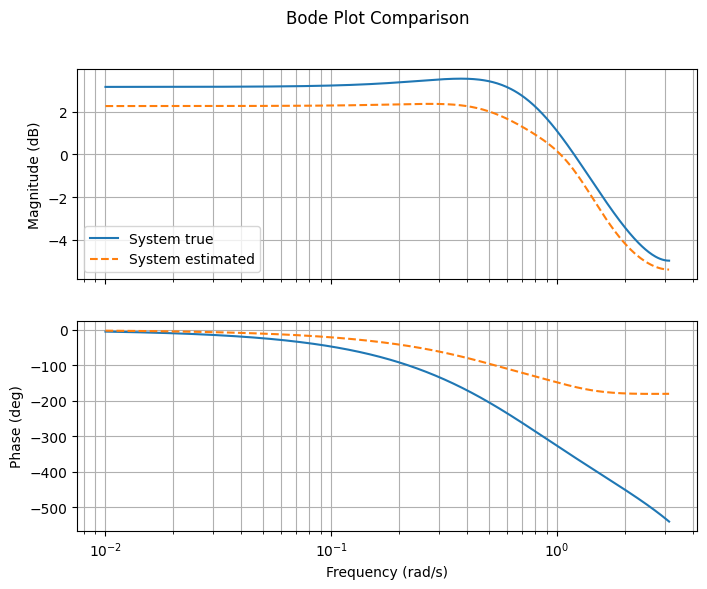

tensor([0.5399, 0.5399, 0.5358, 0.5879, 0.5691], dtype=torch.float64)


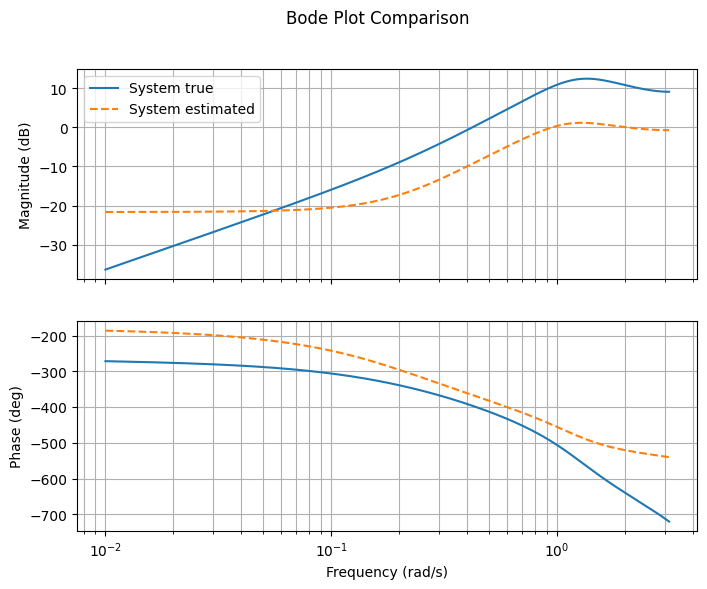

norm (True system): 3.0443522076925467
norm (Estimated system): 0.8980818682045288
Suggested scale correction factor for true system: 0.3285
Suggested scale correction factor for estimated system: 1.1135
H2 norm of difference: 3.3183
Hinf norm of difference: 4.1858
H2 norm of difference: 1.5306
[[-0.00018409]] [[-0.0921905]]
[[0.00018409]] [[0.0921905]]
H2 norm of the real: 0.9999999999999992 H2 norm of estimated: 1.0
H2 norm of difference: 1.5306
Hinf norm of difference: 1.9583


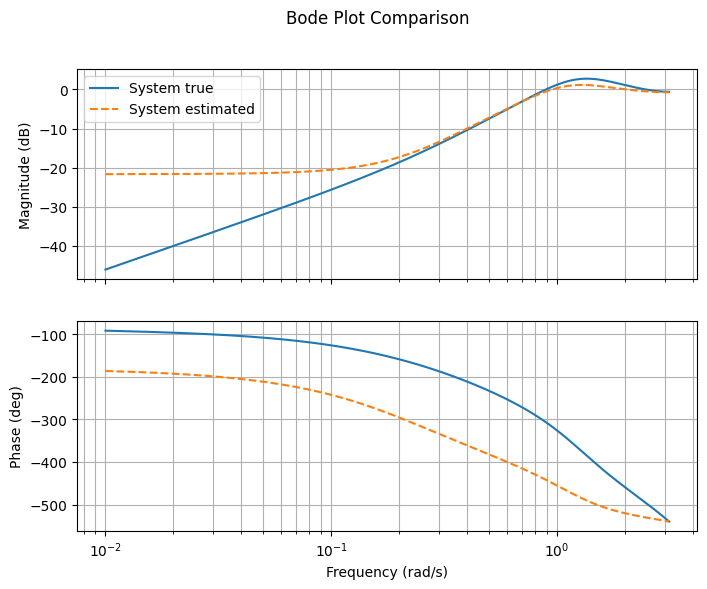

tensor([0.5188, 0.5188, 0.5849, 0.5849, 0.5471], dtype=torch.float64)


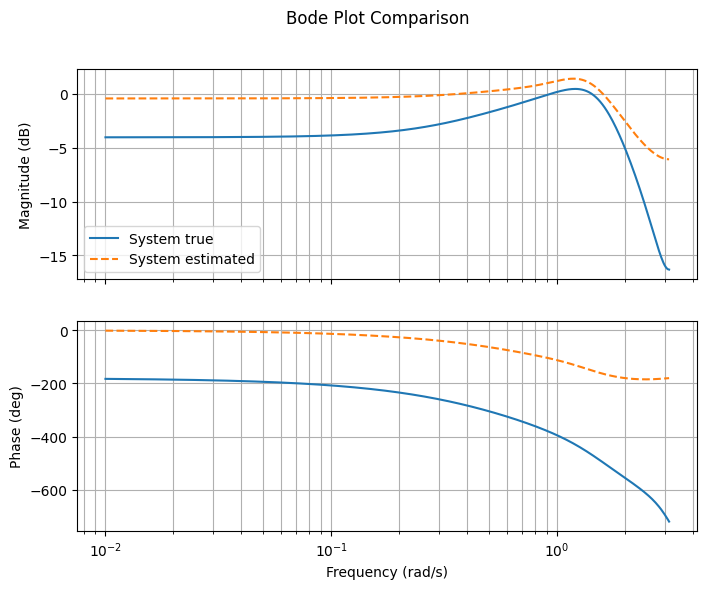

norm (True system): 0.7205559581949917
norm (Estimated system): 0.8976849535896293
Suggested scale correction factor for true system: 1.3878
Suggested scale correction factor for estimated system: 1.1140
H2 norm of difference: 1.0375
Hinf norm of difference: 1.6087
H2 norm of difference: 1.2710
[[-0.87355528]] [[1.0627316]]
[[0.87355528]] [[1.0627316]]
H2 norm of the real: 1.0 H2 norm of estimated: 1.0
H2 norm of difference: 1.5442
Hinf norm of difference: 2.4619


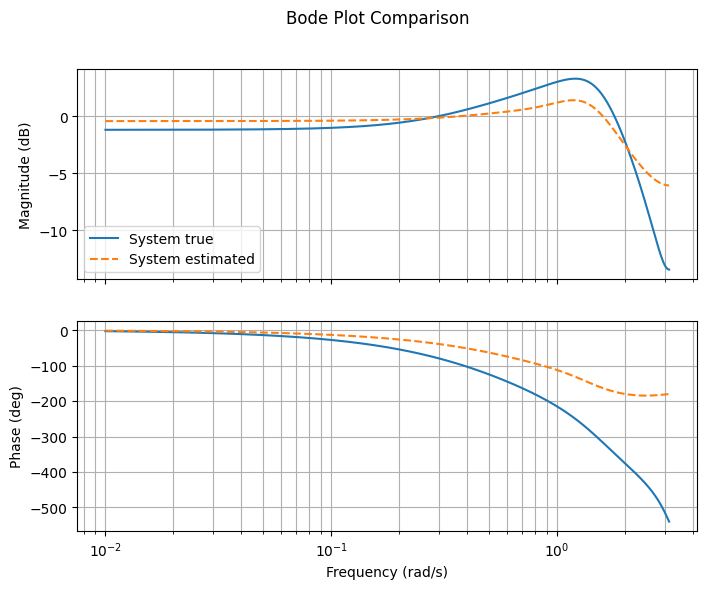

tensor([0.5964, 0.5964, 0.5764, 0.5091, 0.5413], dtype=torch.float64)


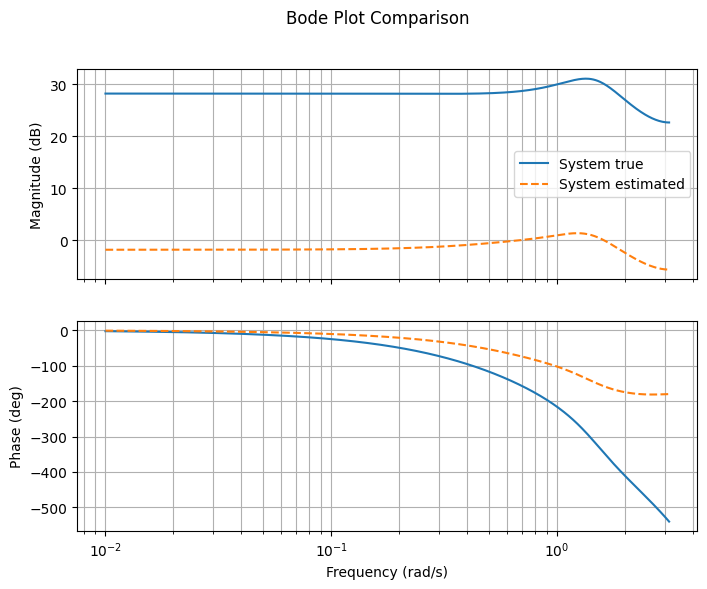

norm (True system): 25.511167143343368
norm (Estimated system): 0.8714065014898319
Suggested scale correction factor for true system: 0.0392
Suggested scale correction factor for estimated system: 1.1476
H2 norm of difference: 25.7132
Hinf norm of difference: 36.8694
H2 norm of difference: 1.5593
[[1.00994554]] [[0.93133564]]
[[1.00994554]] [[0.93133564]]
H2 norm of the real: 0.9999999999999998 H2 norm of estimated: 1.0
H2 norm of difference: 1.5593
Hinf norm of difference: 2.6577


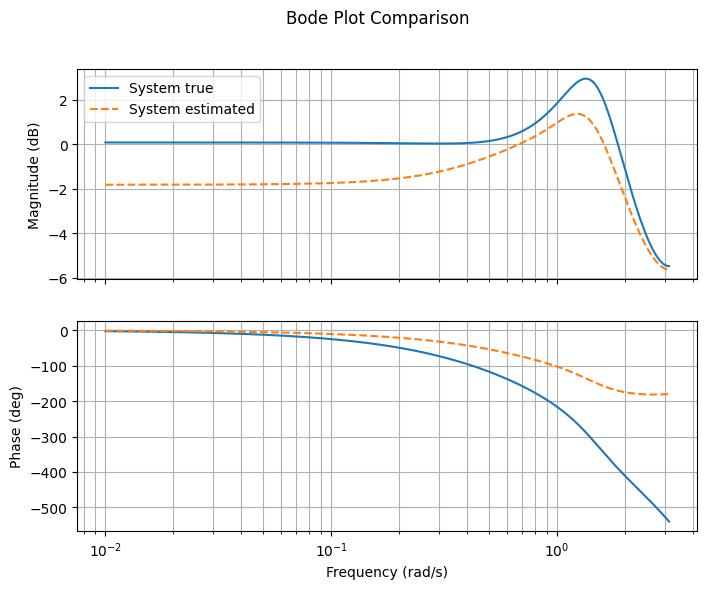

tensor([0.5678, 0.5678, 0.5841, 0.5841, 0.5875], dtype=torch.float64)


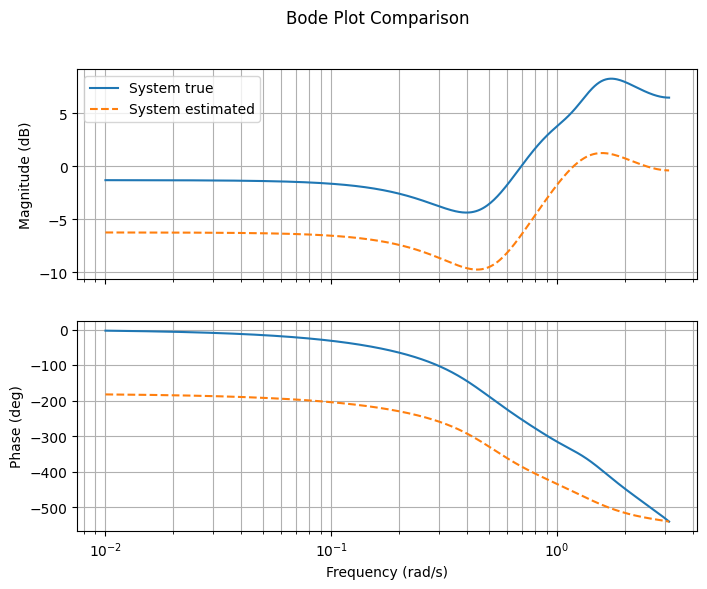

norm (True system): 1.9473614116072546
norm (Estimated system): 0.9030264269249234
Suggested scale correction factor for true system: 0.5135
Suggested scale correction factor for estimated system: 1.1074
H2 norm of difference: 1.9307
Hinf norm of difference: 2.9199
H2 norm of difference: 1.2245
[[0.44169625]] [[-0.53938545]]
[[0.44169625]] [[0.53938545]]
H2 norm of the real: 1.0 H2 norm of estimated: 0.9999999999999999
H2 norm of difference: 1.5813
Hinf norm of difference: 2.1419


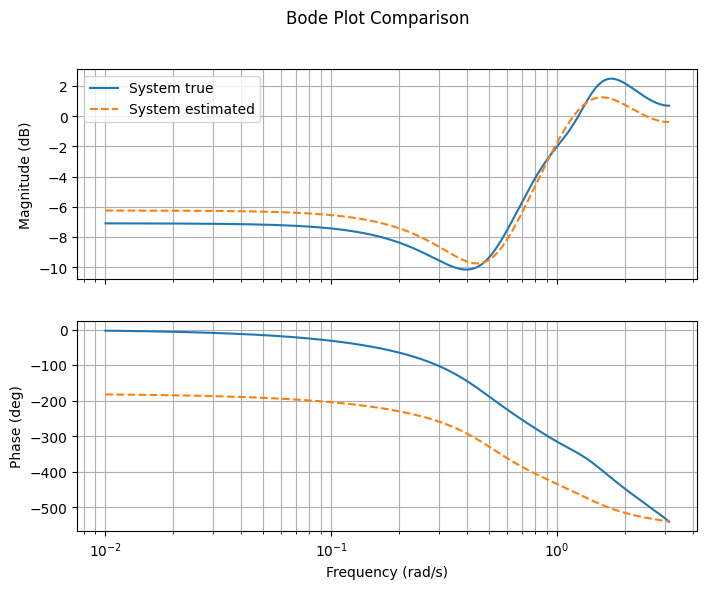

In [19]:
import numpy as np
import control
import matplotlib.pyplot as plt

def norm_system(A, B, C, D, dt=1):
    sys = control.ss(A, B, C, D, dt=dt)
    h2_norm = control.norm(sys, p=2)

    # Scale output matrices to normalize norm
    return h2_norm

vect_worse = [vec_old_idx[i] for i in top_k_indices]
for idx in vect_worse:

    eigenvalues, eigenvectors = torch.linalg.eig(params['A1'][idx])
    print(eigenvalues.abs())

    from scipy.linalg import solve_discrete_lyapunov

    X = solve_discrete_lyapunov(params['A1'][idx], params['B1'][idx] @ params['B1'][idx].T)
    if np.any(np.isnan(X)) or np.any(np.isinf(X)):
        print("Lyapunov solution invalid - possible instability or numerical problem")

    A1, B1, C1, D1 = params['A1'].numpy(), params['B1'].numpy(), params['C1'].numpy(), params['D1'].numpy()
    A1_hat, B1_hat, C1_hat, D1_hat = (wh_parameters_batch['A1'].numpy(), wh_parameters_batch['B1'].numpy(),
                                    wh_parameters_batch['C1'].numpy(), wh_parameters_batch['D1'].numpy())




    batch_size = A1.shape[0]
    h2_dists = []
    hinf_dists = []
    dt = 1
    # example index you want to inspect

    # Initialize true and estimated system
    sys_ss = control.ss(A1[idx], B1[idx], C1[idx], D1[idx], dt=dt)
    sys_ss_hat = control.ss(A1_hat[idx], B1_hat[idx], C1_hat[idx], D1_hat[idx], dt=dt)

    sys_tf = control.ss2tf(sys_ss)
    sys_tf_hat = control.ss2tf(sys_ss_hat)
    delta_sys = sys_tf_hat - sys_tf

    # Frequency points for Bode plot
    omega_nyquist = np.pi / dt
    omega = np.logspace(-2, np.log10(omega_nyquist), 500)  # from 0.01 to Nyquist rad/s

    # Compute Bode magnitude and phase (linear magnitude)
    mag1, phase1, _ = control.bode(sys_ss, omega=omega, dB=False, plot=False)
    mag2, phase2, _ = control.bode(sys_ss_hat, omega=omega, dB=False, plot=False)

    # Calculate Bode magnitude in dB for plotting
    mag1_dB = 20 * np.log10(mag1)
    mag2_dB = 20 * np.log10(mag2)

    # Plot Bode comparison
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,6))
    axs[0].semilogx(omega, mag1_dB, label='System true')
    axs[0].semilogx(omega, mag2_dB, label='System estimated', linestyle='--')
    axs[0].set_ylabel("Magnitude (dB)")
    axs[0].legend()
    axs[0].grid(True, which="both")

    axs[1].semilogx(omega, phase1 * 180 / np.pi)
    axs[1].semilogx(omega, phase2 * 180 / np.pi, linestyle='--')
    axs[1].set_ylabel("Phase (deg)")
    axs[1].set_xlabel("Frequency (rad/s)")
    axs[1].grid(True, which="both")
    plt.suptitle("Bode Plot Comparison")
    plt.show()

    # --- Additional diagnostic tests ---

    # 1. Compute and print DC gain for true and estimated system

    h2_true = norm_system(A1[idx], B1[idx], C1[idx], D1[idx], dt)
    h2_est = norm_system(A1_hat[idx], B1_hat[idx], C1_hat[idx], D1_hat[idx], dt)

    print(f"norm (True system): {h2_true}")
    print(f"norm (Estimated system): {h2_est}")

    # 2. Compute constant gain ratio based on DC gains if possible

    if h2_true < 1e-12:
        scale = 1.0
    else:
        scale = 1.0 / h2_true
        print(f"Suggested scale correction factor for true system: {scale:.4f}")

    if h2_est < 1e-12:
        scale_est = 1.0
    else:
        scale_est = 1.0 / h2_est
        print(f"Suggested scale correction factor for estimated system: {scale_est:.4f}")

    # 3. Compute H2 and Hinf norms of the difference (optional, for this index)
    h2_diff = control.norm(delta_sys, p=2)
    hinf_diff = control.norm(delta_sys, p='inf')

    print(f"H2 norm of difference: {h2_diff:.4f}")
    print(f"Hinf norm of difference: {hinf_diff:.4f}")


    # 5. Optional: Rescale the estimated magnitude plots by the scale correction and plot to verify
    # if scale is not None:
    #     mag2_dB_corrected = 20 * np.log10(mag2 / scale)
        
    #     plt.figure(figsize=(8,4))
    #     plt.semilogx(omega, mag1_dB, label='True')
    #     plt.semilogx(omega, mag2_dB, label='Estimated, original', linestyle='--')
    #     plt.semilogx(omega, mag2_dB_corrected, label='True, unit norm scaled', linestyle='-.')
    #     plt.ylabel("Magnitude (dB)")
    #     plt.xlabel("Frequency (rad/s)")
    #     plt.title("Magnitude Response with Scale Correction")
    #     plt.legend()
    #     plt.grid(True, which='both')
    #     plt.show()

    C_scaled = C1[idx]*scale
    C_scaled_hat = C1_hat[idx]*scale_est
    D_scaled = D1[idx]*scale
    D_scaled_hat = D1_hat[idx]*scale_est

    sys_ss_scaled = control.ss(A1[idx], B1[idx], C_scaled, D_scaled, dt=dt)
    sys_ss_hat_scaled = control.ss(A1_hat[idx], B1_hat[idx], C_scaled_hat, D_scaled_hat, dt=dt)

    delta_sys_new = sys_ss_scaled - sys_ss_hat_scaled
    h2_diff = control.norm(delta_sys_new, p=2)
    print(f"H2 norm of difference: {h2_diff:.4f}")


    dcgain = C_scaled @ np.linalg.inv(np.eye(cfg.nx) - A1[idx]) @ B1[idx] + D_scaled
    dcgain_hat = C_scaled_hat @ np.linalg.inv(np.eye(cfg.nx) - A1_hat[idx]) @ B1_hat[idx] + D_scaled_hat

    print(C_scaled @ np.linalg.inv(np.eye(cfg.nx) - A1[idx]) @ B1[idx] + D_scaled,C_scaled_hat @ np.linalg.inv(np.eye(cfg.nx) - A1_hat[idx]) @ B1_hat[idx] + D_scaled_hat)

    C_scaled = C_scaled*np.sign(dcgain)
    D_scaled = D_scaled*np.sign(dcgain)

    C_scaled_hat = C_scaled_hat*np.sign(dcgain_hat)
    D_scaled_hat = D_scaled_hat*np.sign(dcgain_hat)


    sys_ss_scaled = control.ss(A1[idx], B1[idx], C_scaled, D_scaled, dt=dt)
    sys_ss_hat_scaled = control.ss(A1_hat[idx], B1_hat[idx], C_scaled_hat, D_scaled_hat, dt=dt)

    print(C_scaled @ np.linalg.inv(np.eye(cfg.nx) - A1[idx]) @ B1[idx] + D_scaled,C_scaled_hat @ np.linalg.inv(np.eye(cfg.nx) - A1_hat[idx]) @ B1_hat[idx] + D_scaled_hat)

    print(f"H2 norm of the real: {control.norm(sys_ss_scaled, p=2)}",f"H2 norm of estimated: {control.norm(sys_ss_hat_scaled, p=2)}")

    delta_sys_new = sys_ss_scaled - sys_ss_hat_scaled
    h2_diff = control.norm(delta_sys_new, p=2)
    hinf_diff = control.norm(delta_sys_new, p='inf')

    print(f"H2 norm of difference: {h2_diff:.4f}")
    print(f"Hinf norm of difference: {hinf_diff:.4f}")


    # Frequency points for Bode plot
    omega_nyquist = np.pi / dt
    omega = np.logspace(-2, np.log10(omega_nyquist), 500)  # from 0.01 to Nyquist rad/s

    # Compute Bode magnitude and phase (linear magnitude)
    mag1, phase1, _ = control.bode(sys_ss_scaled, omega=omega, dB=False, plot=False)
    mag2, phase2, _ = control.bode(sys_ss_hat, omega=omega, dB=False, plot=False)

    # Calculate Bode magnitude in dB for plotting
    mag1_dB = 20 * np.log10(mag1)
    mag2_dB = 20 * np.log10(mag2)

    # Plot Bode comparison
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,6))
    axs[0].semilogx(omega, mag1_dB, label='System true')
    axs[0].semilogx(omega, mag2_dB, label='System estimated', linestyle='--')
    axs[0].set_ylabel("Magnitude (dB)")
    axs[0].legend()
    axs[0].grid(True, which="both")

    axs[1].semilogx(omega, phase1 * 180 / np.pi)
    axs[1].semilogx(omega, phase2 * 180 / np.pi, linestyle='--')
    axs[1].set_ylabel("Phase (deg)")
    axs[1].set_xlabel("Frequency (rad/s)")
    axs[1].grid(True, which="both")
    plt.suptitle("Bode Plot Comparison")
    plt.show()


        


In [17]:
from torch.nn import functional as F

def mlp_single(x, w1, b1, w2, b2):
    # x: (seq_len, 1)
    out = torch.matmul(x, w1) + b1  # (seq_len, hidden_dim)
    out = F.relu(out)
    out = torch.matmul(out, w2) + b2  # (seq_len, 1)
    return out

inp = torch.linspace(-6,6, steps = 1000).unsqueeze(-1)

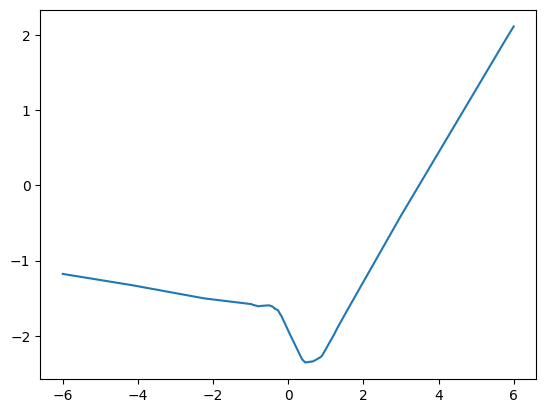

In [18]:
outp = mlp_single(inp.double(),params['w1'][idx],params['b1'][idx],params['w2'][idx],params['b2'][idx])
plt.plot(inp,outp)

In [17]:
import numpy as np
import control

A1, B1, C1, D1 = params['A1'].numpy(), params['B1'].numpy(), params['C1'].numpy(), params['D1'].numpy()
A1_hat, B1_hat, C1_hat, D1_hat = (
    wh_parameters_batch['A1'].numpy(), wh_parameters_batch['B1'].numpy(),
    wh_parameters_batch['C1'].numpy(), wh_parameters_batch['D1'].numpy()
)

batch_size = A1.shape[0]
h2_dists = []
hinf_dists = []
h2_trues = []
h2_ests = []
relative_h2_dists = []
C1_normalized = []
D1_normalized = []
vec_old_idx = []
dt = 1  # example sampling time


def norm_system(A, B, C, D, dt=1):
    sys = control.ss(A, B, C, D, dt=dt)
    h2_norm = control.norm(sys, p=2)

    # Scale output matrices to normalize norm
    return h2_norm

for i in range(batch_size):
    # Compute DC gains for true and estimated systems

    h2_true = norm_system(A1[i], B1[i], C1[i], D1[i], dt)
    h2_est = norm_system(A1_hat[i], B1_hat[i], C1_hat[i], D1_hat[i], dt)

    # print(f"norm (True system): {h2_true}")
    # print(f"norm (Estimated system): {h2_est}")

    # 2. Compute constant gain ratio based on DC gains if possible

    if h2_true < 1e-12:
        scale = 1.0
    else:
        scale = 1.0 / h2_true
        # print(f"Suggested scale correction factor for true system: {scale:.4f}")

    if h2_est < 1e-12:
        scale_est = 1.0
    else:
        scale_est = 1.0 / h2_est
        # print(f"Suggested scale correction factor for estimated system: {scale_est:.4f}")
    if h2_true <np.inf and h2_est<np.inf:
            

        # Form state-space systems
        C_scaled = C1[i]*scale
        C_scaled_hat = C1_hat[i]*scale_est
        D_scaled = D1[i]*scale
        D_scaled_hat = D1_hat[i]*scale_est

        dcgain = C_scaled @ np.linalg.inv(np.eye(cfg.nx) - A1[i]) @ B1[i] + D_scaled
        dcgain_hat = C_scaled_hat @ np.linalg.inv(np.eye(cfg.nx) - A1_hat[i]) @ B1_hat[i] + D_scaled_hat

        sys_ss_norm = control.ss(A1[i], B1[i], C_scaled * np.sign(dcgain), D_scaled * np.sign(dcgain), dt=dt)
        sys_ss_hat_norm = control.ss(A1_hat[i], B1_hat[i], C_scaled_hat * np.sign(dcgain_hat), D_scaled_hat * np.sign(dcgain_hat), dt=dt)

        sys_tf = control.ss2tf(sys_ss_norm)
        sys_tf_hat = control.ss2tf(sys_ss_hat_norm)
        delta_sys = sys_ss_hat_norm - sys_ss_norm

        # Norm calculations
        h2_diff = control.norm(delta_sys, p=2)
        if h2_diff <np.inf:
            h2_true = control.norm(sys_tf, p=2)
            h2_est = control.norm(sys_tf_hat, p=2)
            
            vec_old_idx.append(i)
            h2_trues.append(h2_true)
            h2_ests.append(h2_est)
            h2_dists.append(h2_diff)
            hinf_dists.append(control.norm(delta_sys, p='inf'))

            if h2_true > 1e-12:
                relative_h2_dists.append(h2_diff / h2_true)
            else:
                relative_h2_dists.append(np.nan)
    else: 
        print(f"inf_norm index {i}")

h2_dists = np.array(h2_dists)
hinf_dists = np.array(hinf_dists)
relative_h2_dists = np.array(relative_h2_dists)

# print("H2 norms of differences:", h2_dists)
# print("Relative H2 norms differences:", relative_h2_dists)
# Uncomment to print Hinf differences:
# print("Hinf norms of differences:", hinf_dists)
k = 5  # Number of top values you want
top_k_indices = np.argsort(h2_dists)[-k:]   # Returns indices of k largest, in ascending order
print("Indices of top 2 biggest values:", [vec_old_idx[i] for i in top_k_indices])
print("Corresponding values:", h2_dists[top_k_indices])

inf_norm index 2
inf_norm index 17
inf_norm index 25
inf_norm index 34
inf_norm index 40
inf_norm index 44
inf_norm index 60
inf_norm index 66
inf_norm index 70
inf_norm index 72
inf_norm index 80
inf_norm index 83
inf_norm index 94
Indices of top 2 biggest values: [57, 49, 106, 12, 14]
Corresponding values: [1.51270532 1.53056652 1.54416777 1.55930412 1.5813182 ]


In [15]:
np.mean(h2_dists)

0.5341362268297435

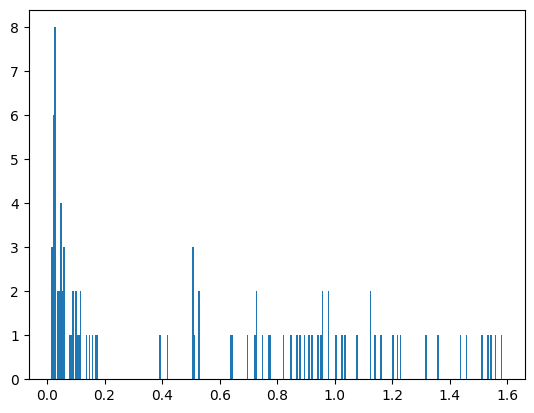

In [45]:
h2_dists_array = np.array(h2_dists)


plt.hist(h2_dists, bins=300)



plt.show()

In [14]:
np.argmax(h2_dists)

71

In [15]:
h2_dists[np.argmax(h2_dists)]

2.015268955266523

In [19]:
h2_trues[np.argmax(h2_dists)]

1.0000000000004357

tensor([0.5474, 0.5474, 0.5128, 0.5476, 0.5426], dtype=torch.float64)


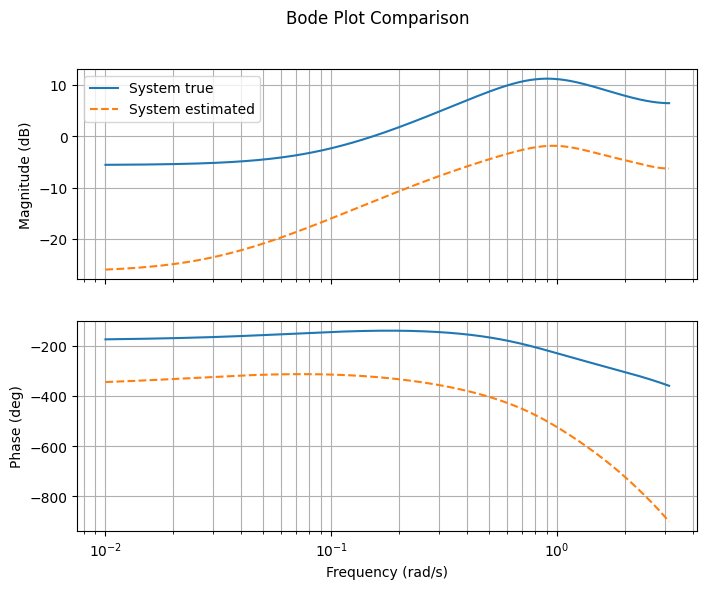

norm (True system): 2.639238618947024
norm (Estimated system): 0.6012685420940267
Suggested scale correction factor for true system: 0.3789
Suggested scale correction factor for estimated system: 1.6632
H2 norm of difference: 2.5989
Hinf norm of difference: 3.6701
H2 norm of difference: 1.2802
[[-0.19837165]] [[0.07979377]]
[[0.19837165]] [[0.07979377]]
H2 norm of the real: 0.9999999999999999 H2 norm of estimated: 0.9999999999999999
H2 norm of difference: 1.5366
Hinf norm of difference: 2.3922


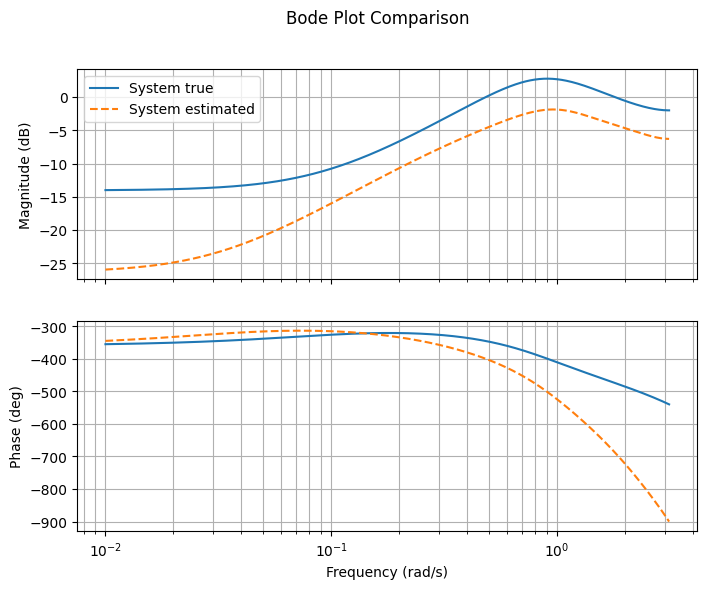

tensor([0.5592, 0.5219, 0.5219, 0.5032, 0.5032], dtype=torch.float64)


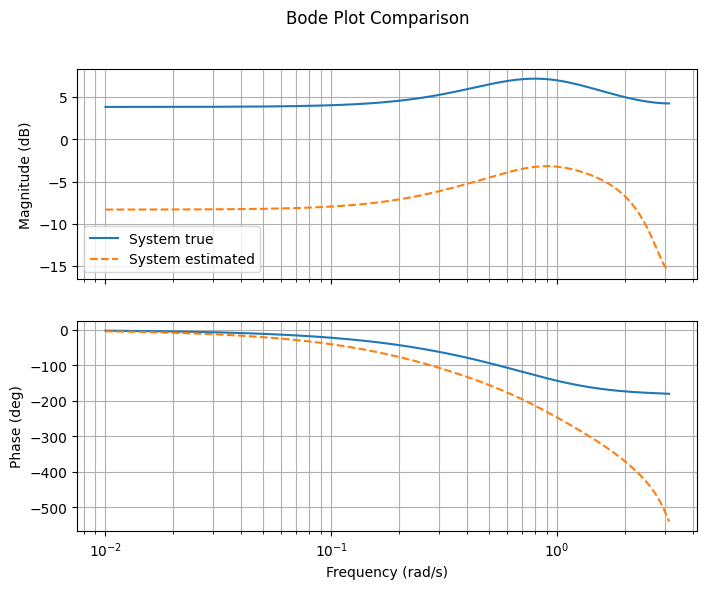

norm (True system): 1.8974329387701603
norm (Estimated system): 0.5025010535827874
Suggested scale correction factor for true system: 0.5270
Suggested scale correction factor for estimated system: 1.9900
H2 norm of difference: 2.0585
Hinf norm of difference: 2.5379
H2 norm of difference: 1.5503
[[0.81955756]] [[0.76304583]]
[[0.81955756]] [[0.76304583]]
H2 norm of the real: 0.9999999999999999 H2 norm of estimated: 0.9999999999999998
H2 norm of difference: 1.5503
Hinf norm of difference: 2.1510


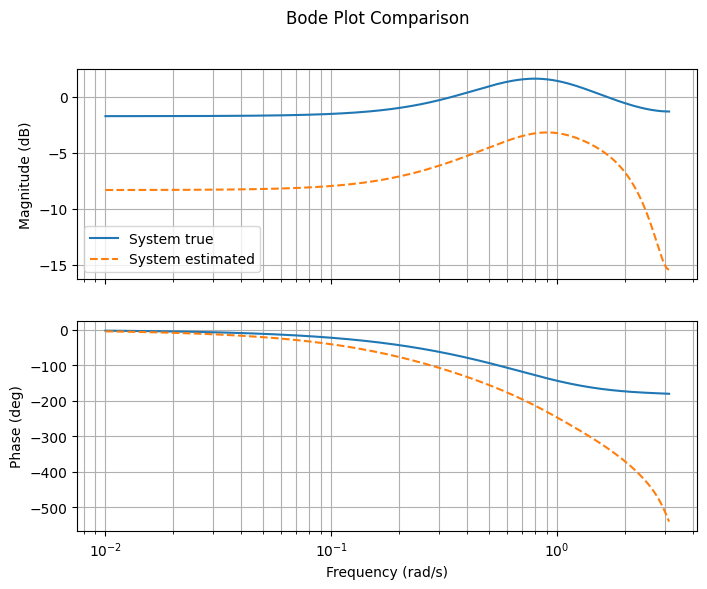

tensor([0.5095, 0.5095, 0.5691, 0.5691, 0.5084], dtype=torch.float64)


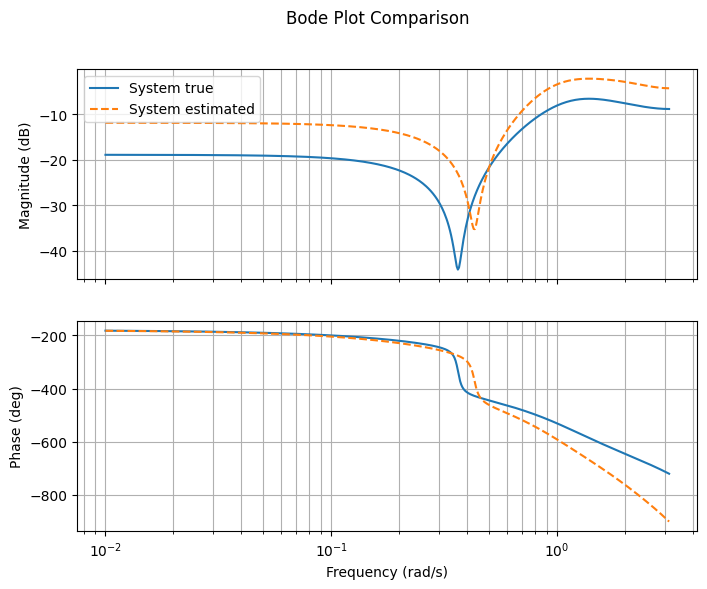

norm (True system): 0.3573651400183272
norm (Estimated system): 0.6069245950033203
Suggested scale correction factor for true system: 2.7983
Suggested scale correction factor for estimated system: 1.6477
H2 norm of difference: 0.7785
Hinf norm of difference: 0.9872
H2 norm of difference: 1.5833
[[-0.31720078]] [[-0.41986407]]
[[0.31720078]] [[0.41986407]]
H2 norm of the real: 1.0000000000000002 H2 norm of estimated: 1.0
H2 norm of difference: 1.5833
Hinf norm of difference: 2.0326


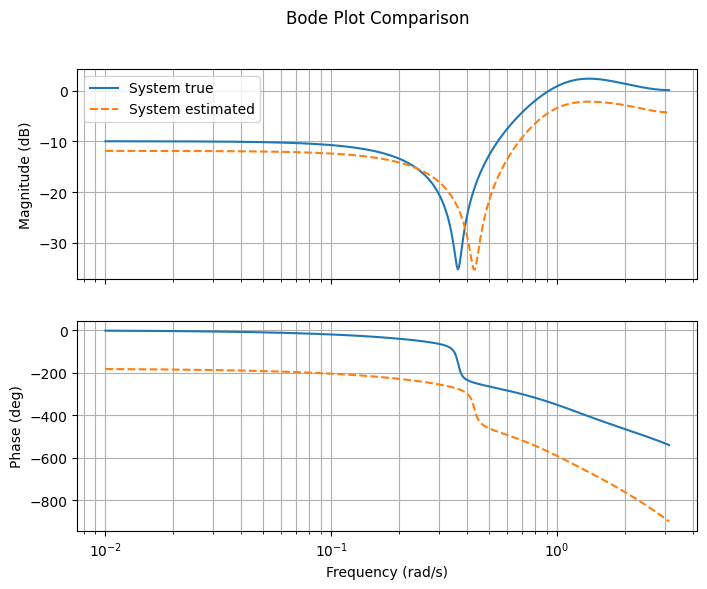

tensor([0.5216, 0.5216, 0.5586, 0.5586, 0.5765], dtype=torch.float64)


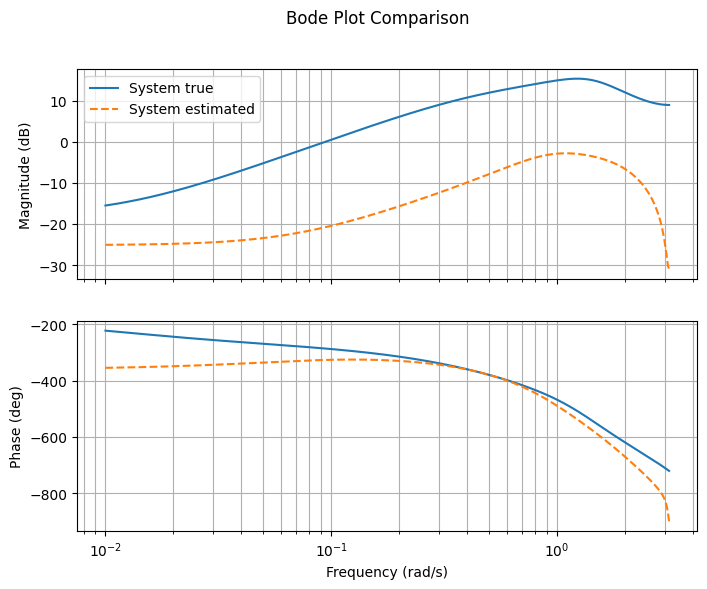

norm (True system): 4.152248295672486
norm (Estimated system): 0.46996550217704824
Suggested scale correction factor for true system: 0.2408
Suggested scale correction factor for estimated system: 2.1278
H2 norm of difference: 3.7973
Hinf norm of difference: 5.2435
H2 norm of difference: 0.6640
[[-0.03116475]] [[0.1177615]]
[[0.03116475]] [[0.1177615]]
H2 norm of the real: 0.9999999999999999 H2 norm of estimated: 1.0
H2 norm of difference: 1.8866
Hinf norm of difference: 2.8530


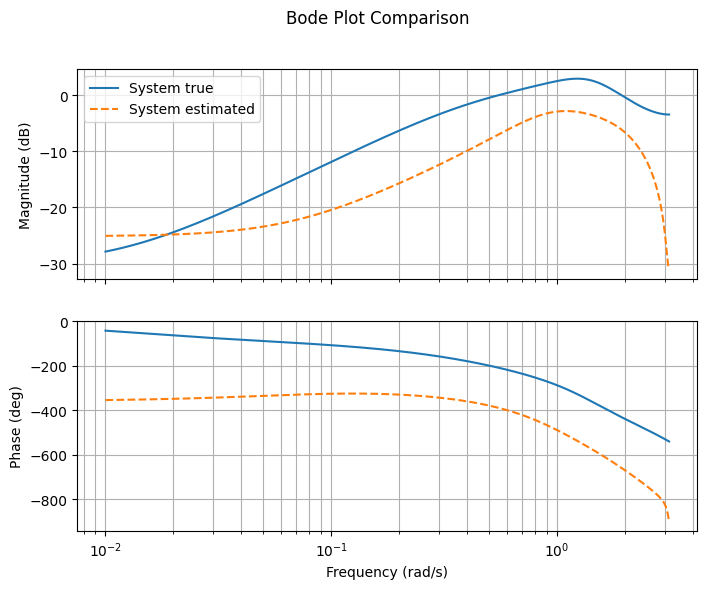

tensor([0.5129, 0.5129, 0.5846, 0.5330, 0.5354], dtype=torch.float64)


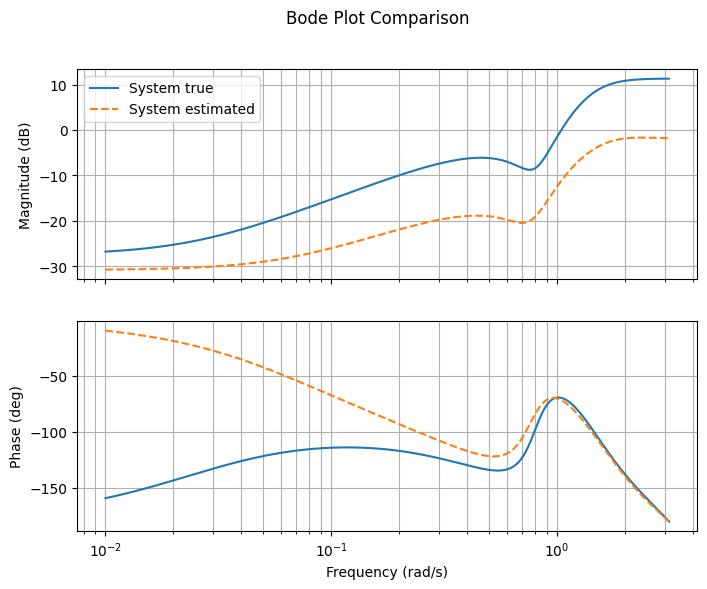

norm (True system): 2.6480441536178314
norm (Estimated system): 0.6077779567451667
Suggested scale correction factor for true system: 0.3776
Suggested scale correction factor for estimated system: 1.6453
H2 norm of difference: 2.0414
Hinf norm of difference: 2.8564
H2 norm of difference: 0.0543
[[-0.01604282]] [[0.04721891]]
[[0.01604282]] [[0.04721891]]
H2 norm of the real: 1.0 H2 norm of estimated: 1.0
H2 norm of difference: 1.9993
Hinf norm of difference: 2.7254


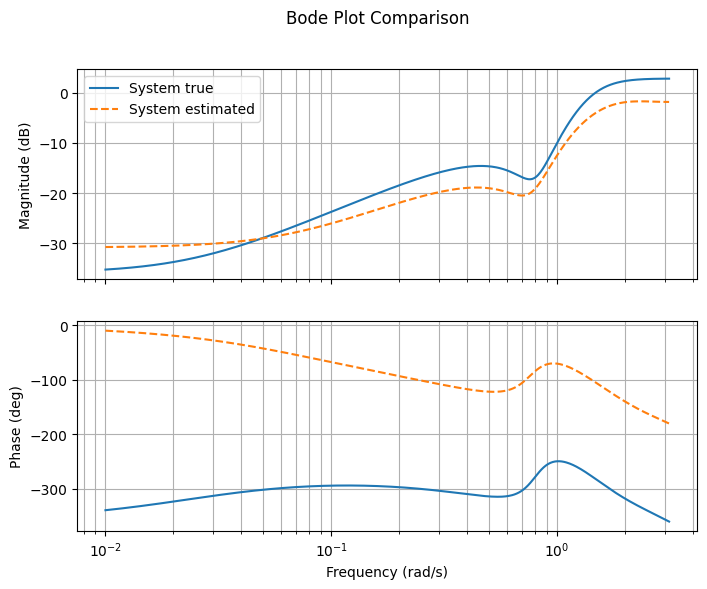

In [16]:
import numpy as np
import control
import matplotlib.pyplot as plt

def norm_system(A, B, C, D, dt=1):
    sys = control.ss(A, B, C, D, dt=dt)
    h2_norm = control.norm(sys, p=2)

    # Scale output matrices to normalize norm
    return h2_norm

vect_worse = [vec_old_idx[i] for i in top_k_indices]
for idx in vect_worse:

    eigenvalues, eigenvectors = torch.linalg.eig(params['A2'][idx])
    print(eigenvalues.abs())

    from scipy.linalg import solve_discrete_lyapunov

    X = solve_discrete_lyapunov(params['A2'][idx], params['B2'][idx] @ params['B2'][idx].T)
    if np.any(np.isnan(X)) or np.any(np.isinf(X)):
        print("Lyapunov solution invalid - possible instability or numerical problem")

    A2, B2, C2, D2 = params['A2'].numpy(), params['B2'].numpy(), params['C2'].numpy(), params['D2'].numpy()
    A2_hat, B2_hat, C2_hat, D2_hat = (wh_parameters_batch['A2'].numpy(), wh_parameters_batch['B2'].numpy(),
                                    wh_parameters_batch['C2'].numpy(), wh_parameters_batch['D2'].numpy())




    batch_size = A2.shape[0]
    h2_dists = []
    hinf_dists = []
    dt = 1
    # example index you want to inspect

    # Initialize true and estimated system
    sys_ss = control.ss(A2[idx], B2[idx], C2[idx], D2[idx], dt=dt)
    sys_ss_hat = control.ss(A2_hat[idx], B2_hat[idx], C2_hat[idx], D2_hat[idx], dt=dt)

    sys_tf = control.ss2tf(sys_ss)
    sys_tf_hat = control.ss2tf(sys_ss_hat)
    delta_sys = sys_tf_hat - sys_tf

    # Frequency points for Bode plot
    omega_nyquist = np.pi / dt
    omega = np.logspace(-2, np.log10(omega_nyquist), 500)  # from 0.01 to Nyquist rad/s

    # Compute Bode magnitude and phase (linear magnitude)
    mag1, phase1, _ = control.bode(sys_ss, omega=omega, dB=False, plot=False)
    mag2, phase2, _ = control.bode(sys_ss_hat, omega=omega, dB=False, plot=False)

    # Calculate Bode magnitude in dB for plotting
    mag1_dB = 20 * np.log10(mag1)
    mag2_dB = 20 * np.log10(mag2)

    # Plot Bode comparison
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,6))
    axs[0].semilogx(omega, mag1_dB, label='System true')
    axs[0].semilogx(omega, mag2_dB, label='System estimated', linestyle='--')
    axs[0].set_ylabel("Magnitude (dB)")
    axs[0].legend()
    axs[0].grid(True, which="both")

    axs[1].semilogx(omega, phase1 * 180 / np.pi)
    axs[1].semilogx(omega, phase2 * 180 / np.pi, linestyle='--')
    axs[1].set_ylabel("Phase (deg)")
    axs[1].set_xlabel("Frequency (rad/s)")
    axs[1].grid(True, which="both")
    plt.suptitle("Bode Plot Comparison")
    plt.show()

    # --- Additional diagnostic tests ---

    # 1. Compute and print DC gain for true and estimated system

    h2_true = norm_system(A2[idx], B2[idx], C2[idx], D2[idx], dt)
    h2_est = norm_system(A2_hat[idx], B2_hat[idx], C2_hat[idx], D2_hat[idx], dt)

    print(f"norm (True system): {h2_true}")
    print(f"norm (Estimated system): {h2_est}")

    # 2. Compute constant gain ratio based on DC gains if possible

    if h2_true < 1e-12:
        scale = 1.0
    else:
        scale = 1.0 / h2_true
        print(f"Suggested scale correction factor for true system: {scale:.4f}")

    if h2_est < 1e-12:
        scale_est = 1.0
    else:
        scale_est = 1.0 / h2_est
        print(f"Suggested scale correction factor for estimated system: {scale_est:.4f}")

    # 3. Compute H2 and Hinf norms of the difference (optional, for this index)
    h2_diff = control.norm(delta_sys, p=2)
    hinf_diff = control.norm(delta_sys, p='inf')

    print(f"H2 norm of difference: {h2_diff:.4f}")
    print(f"Hinf norm of difference: {hinf_diff:.4f}")


    # 5. Optional: Rescale the estimated magnitude plots by the scale correction and plot to verify
    # if scale is not None:
    #     mag2_dB_corrected = 20 * np.log10(mag2 / scale)
        
    #     plt.figure(figsize=(8,4))
    #     plt.semilogx(omega, mag1_dB, label='True')
    #     plt.semilogx(omega, mag2_dB, label='Estimated, original', linestyle='--')
    #     plt.semilogx(omega, mag2_dB_corrected, label='True, unit norm scaled', linestyle='-.')
    #     plt.ylabel("Magnitude (dB)")
    #     plt.xlabel("Frequency (rad/s)")
    #     plt.title("Magnitude Response with Scale Correction")
    #     plt.legend()
    #     plt.grid(True, which='both')
    #     plt.show()

    C_scaled = C2[idx]*scale
    C_scaled_hat = C2_hat[idx]*scale_est
    D_scaled = D2[idx]*scale
    D_scaled_hat = D2_hat[idx]*scale_est


    sys_ss_scaled = control.ss(A2[idx], B2[idx], C_scaled, D_scaled, dt=dt)
    sys_ss_hat_scaled = control.ss(A2_hat[idx], B2_hat[idx], C_scaled_hat, D_scaled_hat, dt=dt)

    delta_sys_new = sys_ss_scaled - sys_ss_hat_scaled
    h2_diff = control.norm(delta_sys_new, p=2)
    print(f"H2 norm of difference: {h2_diff:.4f}")


    dcgain = C_scaled @ np.linalg.inv(np.eye(cfg.nx) - A2[idx]) @ B2[idx] + D_scaled
    dcgain_hat = C_scaled_hat @ np.linalg.inv(np.eye(cfg.nx) - A2_hat[idx]) @ B2_hat[idx] + D_scaled_hat

    print(C_scaled @ np.linalg.inv(np.eye(cfg.nx) - A2[idx]) @ B2[idx] + D_scaled,C_scaled_hat @ np.linalg.inv(np.eye(cfg.nx) - A2_hat[idx]) @ B2_hat[idx] + D_scaled_hat)

    C_scaled = C_scaled*np.sign(dcgain)
    D_scaled = D_scaled*np.sign(dcgain)

    C_scaled_hat = C_scaled_hat*np.sign(dcgain_hat)
    D_scaled_hat = D_scaled_hat*np.sign(dcgain_hat)


    sys_ss_scaled = control.ss(A2[idx], B2[idx], C_scaled, D_scaled, dt=dt)
    sys_ss_hat_scaled = control.ss(A2_hat[idx], B2_hat[idx], C_scaled_hat, D_scaled_hat, dt=dt)

    print(C_scaled @ np.linalg.inv(np.eye(cfg.nx) - A2[idx]) @ B2[idx] + D_scaled,C_scaled_hat @ np.linalg.inv(np.eye(cfg.nx) - A2_hat[idx]) @ B2_hat[idx] + D_scaled_hat)

    print(f"H2 norm of the real: {control.norm(sys_ss_scaled, p=2)}",f"H2 norm of estimated: {control.norm(sys_ss_hat_scaled, p=2)}")

    delta_sys_new = sys_ss_scaled - sys_ss_hat_scaled
    h2_diff = control.norm(delta_sys_new, p=2)
    hinf_diff = control.norm(delta_sys_new, p='inf')

    print(f"H2 norm of difference: {h2_diff:.4f}")
    print(f"Hinf norm of difference: {hinf_diff:.4f}")


    # Frequency points for Bode plot
    omega_nyquist = np.pi / dt
    omega = np.logspace(-2, np.log10(omega_nyquist), 500)  # from 0.01 to Nyquist rad/s

    # Compute Bode magnitude and phase (linear magnitude)
    mag1, phase1, _ = control.bode(sys_ss_scaled, omega=omega, dB=False, plot=False)
    mag2, phase2, _ = control.bode(sys_ss_hat, omega=omega, dB=False, plot=False)

    # Calculate Bode magnitude in dB for plotting
    mag1_dB = 20 * np.log10(mag1)
    mag2_dB = 20 * np.log10(mag2)

    # Plot Bode comparison
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,6))
    axs[0].semilogx(omega, mag1_dB, label='System true')
    axs[0].semilogx(omega, mag2_dB, label='System estimated', linestyle='--')
    axs[0].set_ylabel("Magnitude (dB)")
    axs[0].legend()
    axs[0].grid(True, which="both")

    axs[1].semilogx(omega, phase1 * 180 / np.pi)
    axs[1].semilogx(omega, phase2 * 180 / np.pi, linestyle='--')
    axs[1].set_ylabel("Phase (deg)")
    axs[1].set_xlabel("Frequency (rad/s)")
    axs[1].grid(True, which="both")
    plt.suptitle("Bode Plot Comparison")
    plt.show()


        


In [14]:
import numpy as np
import control

A2, B2, C2, D2 = params['A2'].numpy(), params['B2'].numpy(), params['C2'].numpy(), params['D2'].numpy()
A2_hat, B2_hat, C2_hat, D2_hat = (
    wh_parameters_batch['A2'].numpy(), wh_parameters_batch['B2'].numpy(),
    wh_parameters_batch['C2'].numpy(), wh_parameters_batch['D2'].numpy()
)

batch_size = A2.shape[0]
h2_dists = []
hinf_dists = []
h2_trues = []
h2_ests = []
relative_h2_dists = []
C1_normalized = []
D1_normalized = []
vec_old_idx = []
dt = 1  # example sampling time


def norm_system(A, B, C, D, dt=1):
    sys = control.ss(A, B, C, D, dt=dt)
    h2_norm = control.norm(sys, p=2)

    # Scale output matrices to normalize norm
    return h2_norm

for i in range(batch_size):
    # Compute DC gains for true and estimated systems

    h2_true = norm_system(A2[i], B2[i], C2[i], D2[i], dt)
    h2_est = norm_system(A2_hat[i], B2_hat[i], C2_hat[i], D2_hat[i], dt)

    # print(f"norm (True system): {h2_true}")
    # print(f"norm (Estimated system): {h2_est}")

    # 2. Compute constant gain ratio based on DC gains if possible

    if h2_true < 1e-12:
        scale = 1.0
    else:
        scale = 1.0 / h2_true
        # print(f"Suggested scale correction factor for true system: {scale:.4f}")

    if h2_est < 1e-12:
        scale_est = 1.0
    else:
        scale_est = 1.0 / h2_est
        # print(f"Suggested scale correction factor for estimated system: {scale_est:.4f}")
    if h2_true <np.inf and h2_est<np.inf:
            

        # Form state-space systems
        C_scaled = C2[i]*scale
        C_scaled_hat = C2_hat[i]*scale_est
        D_scaled = D2[i]*scale
        D_scaled_hat = D2_hat[i]*scale_est

        dcgain = C_scaled @ np.linalg.inv(np.eye(cfg.nx) - A2[i]) @ B2[i] + D_scaled
        dcgain_hat = C_scaled_hat @ np.linalg.inv(np.eye(cfg.nx) - A2_hat[i]) @ B2_hat[i] + D_scaled_hat

        sys_ss_norm = control.ss(A2[i], B2[i], C_scaled * np.sign(dcgain), D_scaled * np.sign(dcgain), dt=dt)
        sys_ss_hat_norm = control.ss(A2_hat[i], B2_hat[i], C_scaled_hat * np.sign(dcgain_hat), D_scaled_hat * np.sign(dcgain_hat), dt=dt)

        sys_tf = control.ss2tf(sys_ss_norm)
        sys_tf_hat = control.ss2tf(sys_ss_hat_norm)
        delta_sys = sys_ss_hat_norm - sys_ss_norm

        # Norm calculations
        h2_diff = control.norm(delta_sys, p=2)
        if h2_diff <np.inf:
            h2_true = control.norm(sys_tf, p=2)
            h2_est = control.norm(sys_tf_hat, p=2)
            
            vec_old_idx.append(i)
            h2_trues.append(h2_true)
            h2_ests.append(h2_est)
            h2_dists.append(h2_diff)
            hinf_dists.append(control.norm(delta_sys, p='inf'))

            if h2_true > 1e-12:
                relative_h2_dists.append(h2_diff / h2_true)
            else:
                relative_h2_dists.append(np.nan)
    else: 
        print(f"inf_norm index {i}")

h2_dists = np.array(h2_dists)
hinf_dists = np.array(hinf_dists)
relative_h2_dists = np.array(relative_h2_dists)

# print("H2 norms of differences:", h2_dists)
# print("Relative H2 norms differences:", relative_h2_dists)
# Uncomment to print Hinf differences:
# print("Hinf norms of differences:", hinf_dists)
k = 5  # Number of top values you want
top_k_indices = np.argsort(h2_dists)[-k:]   # Returns indices of k largest, in ascending order
print("Indices of top 2 biggest values:", [vec_old_idx[i] for i in top_k_indices])
print("Corresponding values:", h2_dists[top_k_indices])

inf_norm index 1
inf_norm index 39
inf_norm index 63
inf_norm index 80
inf_norm index 84
inf_norm index 103
inf_norm index 112
Indices of top 2 biggest values: [12, 106, 88, 120, 93]
Corresponding values: [1.53657315 1.55030791 1.58331696 1.8865588  1.99926289]


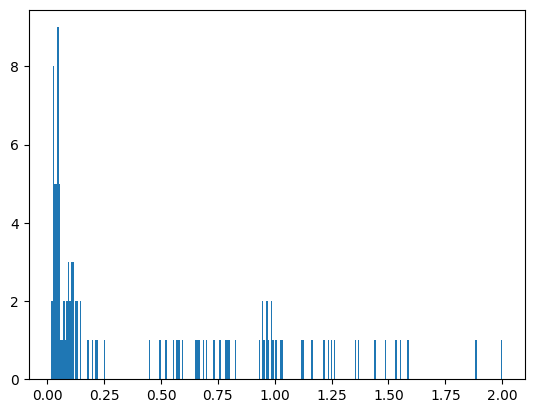

In [35]:
h2_dists_array = np.array(h2_dists)


plt.hist(h2_dists, bins=300)

plt.show()

In [26]:
np.mean(h2_dists)

0.4730485743630305

In [15]:
print(batch_y_mean.mean(),batch_y_mean.std())

0.0012994989266028661 0.9748914210249768


In [16]:
print(batch_y_new[:,-cfg.seq_len_new:, 0].mean(),batch_y_new[:,-cfg.seq_len_new:, 0].std())


-0.009370271 0.99901253


In [11]:
batch_y_mean = batch_y_mean.to("cpu").detach().numpy()
batch_y_norm = (batch_y-batch_y.mean(axis = 1)[:,None])/(batch_y.std(axis = 1)[:,None])
batch_y_new = batch_y.to("cpu").detach().numpy()
batch_u_new = batch_u_new.to("cpu").detach().numpy()

In [12]:
print(batch_y_mean.shape,batch_y_new.shape)

(128, 950, 1) (128, 950, 1)


In [13]:
t = np.arange(1, batch_y_new[:,-cfg.seq_len_new:, 0].shape[1]+1)+cfg.seq_len_n_in + cfg.seq_len_ctx+cfg.seq_len_skip
batch_sim_err = batch_y_new[:,-cfg.seq_len_new:, 0] - batch_y_mean[:,-cfg.seq_len_new:,0]

In [14]:
rmse = metrics.rmse_test(batch_y_new[:, -cfg.seq_len_new:, 0], batch_y_mean[:,-cfg.seq_len_new:,0], time_axis=1)
print(f"rmse of WN on WH: {rmse.mean()}")

rmse of WN on WH: 0.1034407781918103


In [78]:
[rmse[vec_old_idx[i]] for i in top_k_indices]

[0.11157630450388385,
 0.05627008579251678,
 0.15947151806417176,
 0.19635419096626175,
 0.053643273494572555,
 0.1252232022806985,
 0.08671571583148781,
 0.10995377694955195,
 0.18862072079572434,
 0.17945624039258248]

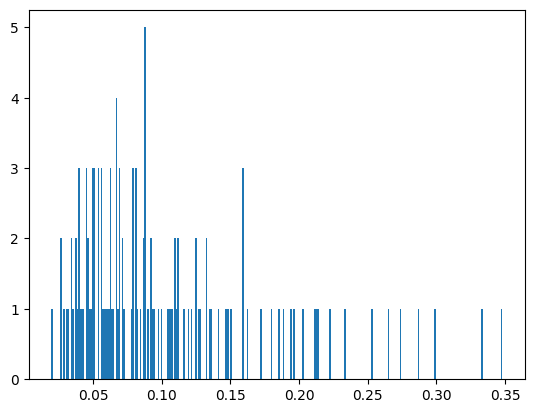

In [77]:
plt.hist(rmse, bins=300)



plt.show()

In [22]:
batch_y_mean[0, -cfg.seq_len_new:, 0].mean()

-0.08254109157431412

(array([26., 46., 28., 15.,  6.,  5.,  1.,  0.,  0.,  1.]),
 array([0.01274856, 0.0246946 , 0.03664064, 0.04858667, 0.06053271,
        0.07247874, 0.08442478, 0.09637082, 0.10831685, 0.12026289,
        0.13220893]),
 <BarContainer object of 10 artists>)

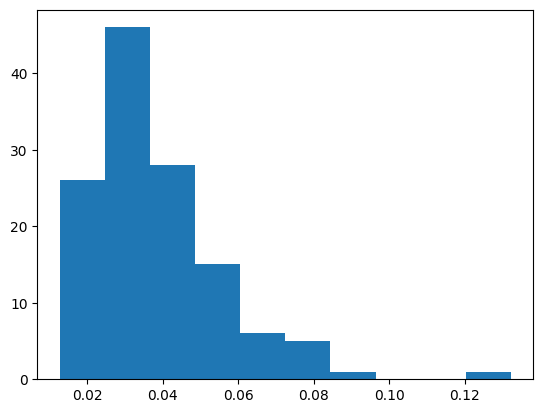

In [32]:
plt.hist(rmse)

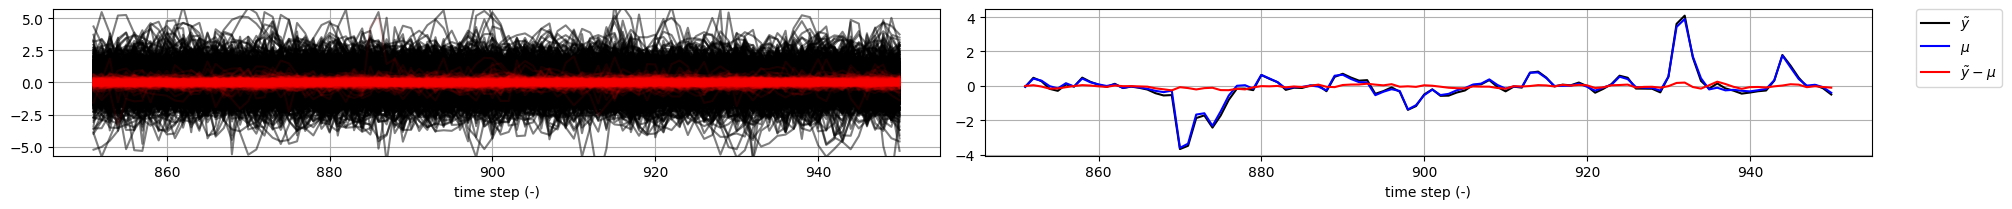

In [24]:
#matplotlib.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica'], 'size': 14})
#matplotlib.rc('text', usetex=True)
#matplotlib.rc('axes', grid=True)
idx = 39
# print(batch_y_new[:,-cfg.seq_len_new:, 0].squeeze(-1).shape,batch_sim_err.shape)
fix, ax = plt.subplots(1,2, sharex=True, sharey=False, figsize=(20, 2.2))
ax[0].plot(t, batch_y_new[:,-cfg.seq_len_new:, :].squeeze(-1).T, "k", alpha=0.5);
ax[0].plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
ax[0].plot(t, batch_sim_err.T, "r", alpha=0.1);
ax[0].plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y-\hat y$")
ax[0].set_ylim((-5.7, 5.7))
ax[0].set_xlabel("time step (-)")
ax[0].grid(True)

ax[1].plot(t, batch_y_new[idx,-cfg.seq_len_new:, 0], 'k', label=r"$\tilde y$")
ax[1].plot(t, batch_y_mean[idx,-cfg.seq_len_new:, 0], 'b', label="$\mu$")
# ax[1].fill_between(x=t, y1=batch_y_minus[idx, :, 0], y2=batch_y_plus[idx, :, 0], color="blue", alpha=0.2)
ax[1].plot(t, batch_sim_err[idx, :], 'r', label=r"$\tilde y - \mu$")
ax[1].set_xlabel("time step (-)")
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
# plt.savefig(fig_path / "wh_sim_batch_single_16000ctx.pdf")
# plt.savefig(fig_path / "wh_sim_batch_single.png")

In [21]:
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_ctx:, 0], batch_y_mean[:,cfg.seq_len_ctx:,0], time_axis=1)
print(f"rmse of multisine on WH: {rmse.mean()}")

ValueError: operands could not be broadcast together with shapes (128,0) (128,530) 

(128, 100) (128, 100)


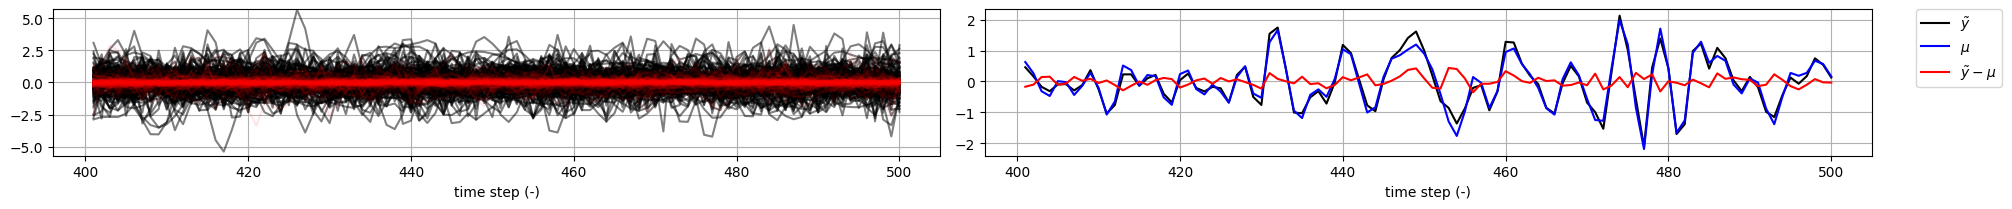

In [22]:
idx = 20
print(batch_y_new[:, cfg.seq_len_ctx:, :].squeeze(-1).shape,batch_sim_err.shape)
fix, ax = plt.subplots(1,2, sharex=True, sharey=False, figsize=(20, 2.2))
ax[0].plot(t, batch_y_new[:, cfg.seq_len_ctx:, :].squeeze(-1).T, "k", alpha=0.5);
ax[0].plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
ax[0].plot(t, batch_sim_err.T, "r", alpha=0.1);
ax[0].plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y-\hat y$")
ax[0].set_ylim((-5.7, 5.7))
ax[0].set_xlabel("time step (-)")
ax[0].grid(True)

ax[1].plot(t, batch_y_new[idx, cfg.seq_len_ctx:, 0], 'k', label=r"$\tilde y$")
ax[1].plot(t, batch_y_mean[idx,cfg.seq_len_ctx:, 0], 'b', label="$\mu$")
# ax[1].fill_between(x=t, y1=batch_y_minus[idx, :, 0], y2=batch_y_plus[idx, :, 0], color="blue", alpha=0.2)
ax[1].plot(t, batch_sim_err[idx, :], 'r', label=r"$\tilde y - \mu$")
ax[1].set_xlabel("time step (-)")
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
# plt.savefig(fig_path / "wh_sim_batch_single_16000ctx.pdf")
# plt.savefig(fig_path / "wh_sim_batch_single.png")

In [14]:
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_ctx:, 0], batch_y_mean[:,cfg.seq_len_ctx:,0], time_axis=1)
print(f"rmse of rbs on WH: {rmse.mean()}")


rmse of rbs on WH: 0.013304765573877131


(128, 100) (128, 100)


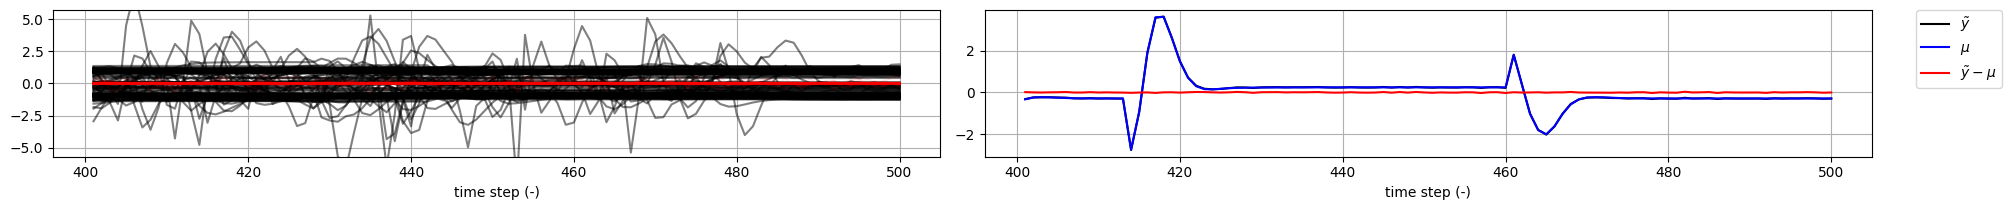

In [15]:
idx = 20
print(batch_y_new[:, cfg.seq_len_ctx:, :].squeeze(-1).shape,batch_sim_err.shape)
fix, ax = plt.subplots(1,2, sharex=True, sharey=False, figsize=(20, 2.2))
ax[0].plot(t, batch_y_new[:, cfg.seq_len_ctx:, :].squeeze(-1).T, "k", alpha=0.5);
ax[0].plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
ax[0].plot(t, batch_sim_err.T, "r", alpha=0.1);
ax[0].plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y-\hat y$")
ax[0].set_ylim((-5.7, 5.7))
ax[0].set_xlabel("time step (-)")
ax[0].grid(True)

ax[1].plot(t, batch_y_new[idx, cfg.seq_len_ctx:, 0], 'k', label=r"$\tilde y$")
ax[1].plot(t, batch_y_mean[idx,cfg.seq_len_ctx:, 0], 'b', label="$\mu$")
# ax[1].fill_between(x=t, y1=batch_y_minus[idx, :, 0], y2=batch_y_plus[idx, :, 0], color="blue", alpha=0.2)
ax[1].plot(t, batch_sim_err[idx, :], 'r', label=r"$\tilde y - \mu$")
ax[1].set_xlabel("time step (-)")
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
# plt.savefig(fig_path / "wh_sim_batch_single_16000ctx.pdf")
# plt.savefig(fig_path / "wh_sim_batch_single.png")

In [ ]:
for name, param in wh.named_parameters():
    # if name in ['A1','B1','C1','D1']:
    diff = wh_parameters_batch[f'{name}']-params[f'{name}']    
    mean_diff = diff.mean(dim = 0)
    print(mean_diff)
    if 1 in mean_diff.shape:
        diff_np = diff.detach().cpu().numpy()
        batch_size, n, m = diff_np.shape
        if m != 1 and n == 1:
            diff_np = np.moveaxis(diff_np, -1, -2)
            batch_size, n, m = diff_np.shape
        all_errors_abs = np.abs(diff_np).flatten()
        all_errors_abs = all_errors_abs[all_errors_abs > 0]  # filter out zeros to avoid log(0)

        vmin_log = all_errors_abs.min() if len(all_errors_abs) > 0 else epsilon
        vmax_log = all_errors_abs.max()
        norm = mcolors.LogNorm(vmin=vmin_log, vmax=vmax_log)

        cmap = cm.viridis

        # Layout: use up to 6 columns for better visibility
        ncols = min(6, n)
        nrows = int(np.ceil(n / ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3 * nrows), constrained_layout=True)
        if nrows == 1:
            axes = np.array([axes])
        axes = axes.flatten()

        epsilon = 1e-10  # small offset for numerical stability in log scale

        for idx in range(n):
            ax = axes[idx]
            errors = np.abs(diff_np)[:, idx]

            # Filter out zeros and negatives (log scale requires > 0)
            if len(errors) == 0:
                # If no positive values, skip plotting this subplot
                ax.axis('off')
                continue

            # Define log spaced bins between min and max positive values
            lower_bound = errors.min()
            upper_bound = errors.max()
            bins = np.logspace(np.log10(lower_bound), np.log10(upper_bound), 21)  # 20 bins

            # Compute histogram with log-spaced bins
            counts, _ = np.histogram(errors, bins=bins)
            bin_centers = 0.5 * (bins[:-1] + bins[1:])

            # Color mapping based on bin centers
            bar_colors = cmap(norm(bin_centers))

            # Plot histogram bars with widths matching log-spaced bin widths
            ax.bar(bin_centers, counts, width=np.diff(bins), color=bar_colors, align='center')

            # Add vertical red line at zero — note zero won't show on log scale
            # You can optionally comment this out as zero is not on log scale
            # ax.axvline(0, color='red', linestyle='--', linewidth=1.5)

            # Set x-axis to log scale
            ax.set_xscale('log')

            ax.set_title(f'Idx {idx}')
            # ax.set_xticks([])
            # ax.set_yticks([])

        # Hide any unused axes
        for ax in axes[n:]:
            ax.axis('off')

        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.03, pad=0.02, label='Error Value')

        plt.suptitle(f'Error Distribution per Vector Entry {name} (Logscale x-axis and bins)', fontsize=16)
        plt.show()
        # mean_diff = mean_diff.squeeze(0)
        # mean_diff = mean_diff.flatten()
        # n = mean_diff.shape[0]
        # x = np.arange(n)

        # plt.figure(figsize=(8, 2))
        # sc = plt.scatter(x, mean_diff, c=mean_diff, cmap='winter', s=100)  # main scatter plot
        # plt.colorbar(sc, label='Mean Difference')
        # plt.xlabel('Bias Index')
        # plt.ylabel('Mean Difference')
        # plt.title(f'Average Bias Difference {name} (Green=Low, Blue=High)')

        # # Overlay red circles for values near zero
        # if [1] != list(mean_diff.shape):
        #     threshold = 0.5  # adjust as needed for "near zero"
        #     near_zero_mask = np.abs(mean_diff) < threshold
        #     plt.scatter(x[near_zero_mask], mean_diff[near_zero_mask],
        #                 facecolors='none', edgecolors='red', s=150, linewidths=2, label='Near Zero')

        # plt.legend(loc='upper right')
        # plt.show()
    
    else:
        diff_np = diff.detach().cpu().numpy()
        batch_size, rows, cols = diff_np.shape
        
        # vmin = np.percentile(diff_np, 1)
        # vmax = np.percentile(diff_np, 99)
        # # vmin, vmax = diff_np.min(), diff_np.max()
        # norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        # cmap = cm.viridis

        # fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows), constrained_layout=True)
        # axes = axes.flatten()

        # for i in range(rows):
        #     for j in range(cols):
        #         ax = axes[i * cols + j]
        #         errors = diff_np[:, i, j]

        #         # Remove outliers: keep only between 5th and 95th percentiles
        #         lower_bound = np.percentile(errors, 1)
        #         upper_bound = np.percentile(errors, 99)
        #         errors_filtered = errors[(errors >= lower_bound) & (errors <= upper_bound)]

        #         # Compute histogram on filtered data
        #         counts, bins = np.histogram(errors_filtered, bins=30)
        #         bin_centers = 0.5 * (bins[:-1] + bins[1:])
        #         colors = cmap(norm(bin_centers))
                
        #         ax.bar(bin_centers, counts, width=(bins[1] - bins[0]), color=colors, align='center')
        #         ax.axvline(0, color='red', linestyle='--', linewidth=1.5)
        #         ax.set_title(f'Elem ({i},{j})')
        #         ax.set_xticks([])
        #         ax.set_yticks([])

        epsilon = 1e-10

        fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows), constrained_layout=True)
        axes = axes.flatten()

        cmap = cm.viridis

        # We will normalize on absolute bin centers, avoiding zero or negative values for LogNorm
        all_errors_abs = np.abs(diff_np).flatten()
        all_errors_abs = all_errors_abs[all_errors_abs > 0]  # filter out zeros to avoid log(0)

        vmin_log = np.percentile(all_errors_abs, 1) if len(all_errors_abs) > 0 else epsilon
        vmax_log = np.percentile(all_errors_abs, 99)

        norm = mcolors.LogNorm(vmin=vmin_log, vmax=vmax_log)
  
        for i in range(rows):
            for j in range(cols):
                ax = axes[i * cols + j]
                errors = np.abs(diff_np)[:, i, j]
                lower_bound = np.percentile(errors, 1)
                upper_bound = np.percentile(errors, 99)
                errors_filtered = errors[(errors >= lower_bound) & (errors <= upper_bound)]

                # Create logarithmically spaced bins between lower_bound and upper_bound
                bins = np.logspace(np.log10(lower_bound), np.log10(upper_bound), 51)  # 50 bins
                counts, _ = np.histogram(errors_filtered, bins=bins)

                bin_centers = 0.5 * (bins[:-1] + bins[1:])
                # Use a colormap or single color, for example:
                colors = cmap(norm(bin_centers))

                ax.bar(bin_centers, counts, width=np.diff(bins), color=colors, align='center')
                # Optional: vertical line at zero (but zero won't be shown in log scale)
                # ax.axvline(0, color='red', linestyle='--', linewidth=1.5)
                ax.set_xscale('log')
                ax.set_title(f'Elem ({i},{j})')
                # ax.set_xticks([])
                # ax.set_yticks([])

        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.03, pad=0.02, label='Absolute Error Value (log scale)')

        plt.suptitle(f'Error Distribution for Each Parameter Element {name} (Outliers Removed)', fontsize=16)
        plt.show()


        # plt.figure(figsize=(6, 5))
        # plt.imshow(mean_diff, cmap='winter')
        # plt.colorbar(label='Mean Difference')
        # plt.title('Average Difference (Green=Low, Blue=High, Red=Near Zero)')
        # plt.xlabel('Column')
        # plt.ylabel('Row')

        # # Overlay red circles for values below a threshold
        # threshold = 0.5  # Define what "near zero" means for you
        # y_idx, x_idx = np.where(np.abs(mean_diff) < threshold)
        # plt.scatter(x_idx, y_idx, facecolors='none', edgecolors='red', s=100, linewidths=0.6, label='Near Zero')

        # plt.legend(loc='upper right')
        # plt.show()
